# Modèles d'apprentissage

__[III Modèles Linéaires](#III-Modèles-Linéaires)__\
[III.1 Chargement des modèles](#III.1-Chargement-des-modèles)\
[III.2 Baseline: Régression linéaire simple](#III.2-Baseline:-Régression-linéaire-simple)\
[III.3 kNN](#III.3-kNN)\
[III.4 Sélection de prédicteurs avec Lasso](#III.4-Sélection-de-prédicteurs-avec-Lasso)\
[III.5 Feature importance avec RandomForest](#III.5-Feature-importance-avec-RandomForest)\

__[IV ENERGYSTARScore](#IV-ENERGYSTARScore)__



In [522]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

# III Modèles
## III.1 Chargement des modèles

In [523]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

set_config(display='diagram')

Chargement des modèles

In [520]:
model1 = pd.read_csv("./model1.csv")
model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5944 entries, 0 to 3375
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     5944 non-null   object 
 1   NumberofBuildings                5944 non-null   float64
 2   NumberofFloors                   5944 non-null   float64
 3   PropertyGFATotal                 5944 non-null   int64  
 4   PropertyGFAParking               5944 non-null   int64  
 5   PropertyGFABuilding(s)           5944 non-null   int64  
 6   LargestPropertyUseTypeGFA        5944 non-null   float64
 7   SecondLargestPropertyUseType     5944 non-null   object 
 8   SecondLargestPropertyUseTypeGFA  5944 non-null   float64
 9   ThirdLargestPropertyUseType      5944 non-null   object 
 10  ThirdLargestPropertyUseTypeGFA   5944 non-null   float64
 11  ENERGYSTARScore                  4546 non-null   float64
 12  SiteEUI(kBtu/sf)    

In [521]:
model2 = pd.read_csv("./model2.csv")
model2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5944 entries, 0 to 3375
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     5944 non-null   object 
 1   NumberofBuildings                5944 non-null   float64
 2   NumberofFloors                   5944 non-null   float64
 3   PropertyGFATotal                 5944 non-null   int64  
 4   PropertyGFAParking               5944 non-null   int64  
 5   PropertyGFABuilding(s)           5944 non-null   int64  
 6   LargestPropertyUseTypeGFA        5944 non-null   float64
 7   SecondLargestPropertyUseTypeGFA  5944 non-null   float64
 8   ThirdLargestPropertyUseTypeGFA   5944 non-null   float64
 9   ENERGYSTARScore                  4546 non-null   float64
 10  SiteEUI(kBtu/sf)                 5944 non-null   float64
 11  SiteEUIWN(kBtu/sf)               5944 non-null   float64
 12  SourceEUI(kBtu/sf)  

On définit également quelques routines pour automatiser les traitements.

In [586]:
def modelpreparation(model, targets=None, energy_cols=None):
    
    if not targets:
        # Sélection des cibles
        targets = ["SiteEnergyUse",
                   "SiteEnergyUse_log",
                   "TotalGHGEmissions", 
                   "TotalGHGEmissions_log",
                   "SiteEUI(kBtu/sf)",
                   "SiteEUIWN(kBtu/sf)",
                   "SourceEUI(kBtu/sf)",
                   "SourceEUIWN(kBtu/sf)",
                   "SiteEnergyUseWN(kBtu)",
                   "SourceEnergyUseWN",
                   "SourceEnergyUse(kBtu)", 
                   "GHGEmissionsIntensity"]
    
    if not energy_cols:
        # retrait des colonnes liées à la consommation d'énergie
        energy_cols = ["Electricity(kBtu)",
                       "NaturalGas(kBtu)",
                       "SteamUse(kBtu)",
                       "ENERGYSTARScore",
                       "NaturalGas_ratio",
                       "Steam_ratio"
                      ]

    # Sélection des prédicteurs
    features = [col for col in model.columns if (col not in targets) and (col not in energy_cols)]

    # Séparation des variables en types "category" et "float64"
    # On change le type des variables numériques non catégorielles en float64
    cols_to_transform = ["PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)"]
    model[cols_to_transform] = model[cols_to_transform].astype("float64")

    # Les variables int64 et object sont passées en type 'category'
    cat_cols = model.dtypes[(model.dtypes=="int64") | (model.dtypes=="object")].index
    model[cat_cols] = model[cat_cols].astype("category")
    
    return model, features

def create_pipeline(model, pca_dict, categorical=True, numeric=True, pca_ncomp=4, regressor=True):
    
    # One-hot encoding of categorical variable
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Standard scaling of numerical features
    numeric_transformer = StandardScaler()
    
    # ACP sur les variables quantitatives
    pca = PCA(n_components=4)
            
    std_pca_transformer = make_pipeline(
        StandardScaler(),
        PCA(n_components=pca_ncomp)
    )    
    
    pca_cols, pca_index = pca_dict["cols"], pca_dict["index"]
    
    preprocessor1 = ColumnTransformer(transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="category")),
        ('std_pca', std_pca_transformer, pca_cols),
        ('cat', categorical_transformer, selector(dtype_include="category"))],
                                      remainder='passthrough')
    
    preprocessor2 = ColumnTransformer(transformers=[('drop_pca', 'drop', pca_index)], 
                                      remainder='passthrough'
                                     )
    #preprocessor3 = ColumnTransformer(remainder='passthrough')
    #test_pipeline = Pipeline(steps=[('preprocessor1', preprocessor1), 
    #                      ('preprocessor2', preprocessor2), ('last', 'passthrough')])
    
    # Création du pipeline comprenant les deux étapes de preprocessing et l'étape de régression
    reg = Pipeline(steps=[('preprocessor1', preprocessor1), 
                          ('preprocessor2', preprocessor2),
                          ('regressor', model)
                         ])
    if not regressor:
        reg = Pipeline(steps=[('preprocessor1', preprocessor1), 
                          ('preprocessor2', preprocessor2),
                          ('pass', 'passthrough')
                         ])
    return reg


def crossval_noGS(target, features, df, model, pca=True):
   
    # Séparation prédicteurs - cible
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=0)
    
    if pca:
        # colonnes sur lesquelles appliquer l'ACP
        pca_cols = ["PropertyGFATotal", 
                    "PropertyGFAParking",
                    "PropertyGFABuilding(s)",
                    "LargestPropertyUseTypeGFA",
                    "SecondLargestPropertyUseTypeGFA",
                    "ThirdLargestPropertyUseTypeGFA"]
        
        # Récupération des indices correspondant aux variables sur lesquelles on réalise l'ACP dans le tableau
        # numpy créé après preprocessing1. Le tableau numpy est en effet réorganisé lors du preprocessing avec les
        # colonnes numeriques d'abord, puis les colonnes créées lors de l'ACP et enfin les colonnes catégorielles
        X_train_only_numeric = X_train.select_dtypes(include=['float64'])
        pca_index = [X_train_only_numeric.columns.get_loc(c) for c in pca_cols]
        
    else:
        pca_cols = []
    pca_dict = {"cols": pca_cols, "index":pca_index}
    reg = create_pipeline(model, pca_dict)
    
    # cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    cv = cross_validate(reg, X, y, cv=kf,
                            scoring=('r2',
                                     #'neg_mean_squared_log_error'
                                    ),
                            return_train_score=True)
    
    cv_results = pd.DataFrame(cv).sort_values(by="test_r2", ascending=False)
    moyenne = pd.DataFrame(data=cv_results.to_numpy().mean(axis=0).reshape(1, -1), 
                           columns=cv_results.columns, 
                           index=["moyenne"])
    cv_results = pd.concat([cv_results, moyenne])
    
    #print("Scores: ", scores)
    #print("Score moyen: {:.2f}".format(np.mean(scores)))
    
    return cv_results

def crossval_GS(target, features, df, params, model_gs, score, pca=True, pca_ncomp=4):
    
    # Séparation prédicteurs - cible
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=0)
    
    # Récupération des indices correspondant aux variables sur lesquelles on réalise l'ACP dans le tableau
    # numpy créé après preprocessing1. Le tableau numpy est en effet réorganisé lors du preprocessing avec les
    # colonnes numeriques d'abord, puis les colonnes créées lors de l'ACP et enfin les colonnes catégorielles
    X_train_only_numeric = X_train.select_dtypes(include=['float64'])
    
    if pca:
        # colonnes sur lesquelles appliquer l'ACP
        pca_cols = ["PropertyGFATotal", 
                    "PropertyGFAParking",
                    "PropertyGFABuilding(s)",
                    "LargestPropertyUseTypeGFA",
                    "SecondLargestPropertyUseTypeGFA",
                    "ThirdLargestPropertyUseTypeGFA"]
    else:
        pca_cols = []
    
    
    # Récupération des indices correspondant aux variables sur lesquelles on réalise l'ACP dans le tableau
    # numpy créé après preprocessing1. Le tableau numpy est en effet réorganisé lors du preprocessing avec les
    # colonnes numeriques d'abord, puis les colonnes créées lors de l'ACP et enfin les colonnes catégorielles
    X_train_only_numeric = X_train.select_dtypes(include=['float64'])
    pca_index = [X_train_only_numeric.columns.get_loc(c) for c in pca_cols]
    
    pca_dict = {"cols": pca_cols, "index":pca_index}
    reg = create_pipeline(model, pca_dict, pca_ncomp=pca_ncomp)

    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {}
    for key, values in params.items():
        param_grid["regressor__"+key] = values
        
        
    # Créer une regression Ridge avec sélection d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    reg,            # modèle
    param_grid,     # hyperparamètres à tester
    cv=inner_cv,    # nombre de folds de validation croisée
    scoring=score,   # score à optimiser
    return_train_score=True,
    refit='r2',
    )
    
    # Optimiser cet estimateur sur le jeu d'entraînement
    regr.fit(X_train, y_train)
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)
    
    # Performance en généralisation du meilleur modèle sur le set de validation
    y_pred = regr.predict(X_test)
    print("\nPerformance en généralisation sur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    
    return regr

def print_cvresults(score, regr, param_grid):
    
    # Résultats de la validation croisée
    cv_results = pd.DataFrame(regr.cv_results_).sort_values("mean_test_r2", ascending=False)
    
    param_keys = ["param_regressor__"+k for k in param_grid.keys()]
    param_cols = []
    for sample in ("train", "test"):
        for i in range(len(score)):
            for s in ("mean", "std"):
                param_cols.append("{}_{}_{}".format(s, sample, score[i]))
        
        # Pour rendre positive l'erreur rmse (négative par défaut avec GridSearch)
        try:
            cv_results["mean_{}_{}".format(sample, score[1])] *= -1
        except:
            pass
        
    param_cols += param_keys
    param_cols += ["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time"]
    
    # Performance sur le jeu d'entraînement
    print("Performance(s) moyenne(s) sur le jeu d'entraînement:")
    
    return cv_results, param_cols

def plot_traintestscores(cv_results, score, axis_scale="log", plot_param="alpha"):
    
    # Affiche les scores sur les jeu d'entrainement et de test
    d = cv_results.set_index("param_regressor__{}".format(plot_param))
    cols = []
    for t in ("train", "test"):
        for s in score: 
            cols.append("mean_{}_{}".format(t, s))
            
    sns.lineplot(data=d[cols])
    plt.xscale(axis_scale)
    plt.show()
    
#return cv_results[param_cols], cv_results.iloc[0]
    

## III.2 Baseline: Régression linéaire simple

In [463]:
m1, features = modelpreparation(model1)
model = LinearRegression()
crossval_noGS("SiteEnergyUse_log", features, m1, model)

,fit_time,score_time,test_r2,train_r2
0,0.105437,0.020039,0.556956,0.551783
2,0.075874,0.018085,0.550877,0.555369
1,0.086980,0.017681,0.550100,0.556719
3,0.079802,0.017259,0.545010,0.557658
4,0.092148,0.017424,0.521285,0.563270
moyenne,0.088048,0.018097,0.544846,0.556960


In [464]:
crossval_noGS("TotalGHGEmissions_log", features, m1, model)

,fit_time,score_time,test_r2,train_r2
0,0.093441,0.018659,0.714475,0.704079
1,0.085735,0.017973,0.712549,0.706821
3,0.075227,0.017531,0.704811,0.708477
2,0.078708,0.017110,0.699775,0.709332
4,0.076302,0.019638,0.673911,0.715890
moyenne,0.081883,0.018182,0.701104,0.708920


In [465]:
m2, features = modelpreparation(model2)
model = LinearRegression()
crossval_noGS("SiteEnergyUse_log", features, m2, model)

,fit_time,score_time,test_r2,train_r2
3,0.066129,0.016165,0.544690,0.543573
0,0.072605,0.016485,0.543022,0.540629
1,0.070255,0.016122,0.536114,0.545758
2,0.065100,0.016460,0.529664,0.545985
4,0.066733,0.015602,0.512213,0.551291
moyenne,0.068164,0.016167,0.533141,0.545447


In [466]:
crossval_noGS("TotalGHGEmissions_log", features, m2, model)

,fit_time,score_time,test_r2,train_r2
3,0.062065,0.015784,0.704896,0.698035
0,0.078858,0.017452,0.704127,0.695979
1,0.067592,0.017071,0.703155,0.698604
2,0.059372,0.016099,0.684043,0.702502
4,0.063909,0.014997,0.666537,0.707308
moyenne,0.066359,0.016281,0.692552,0.700486


## III.3 kNN

**Premier modèle**

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 7}

Sur le jeu de test : 0.734


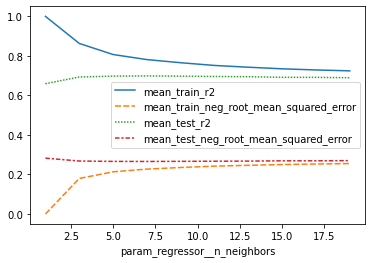

In [546]:
from sklearn.neighbors import KNeighborsRegressor

# chargement du modèle
m1, features = modelpreparation(model1)

# Valeurs possibles du nombre de plus proches voisins
params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = KNeighborsRegressor()

# Preprocessing et fit du modèle
gspipeline = crossval_GS("SiteEnergyUse_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, axis_scale="linear", plot_param="n_neighbors")

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 7}

Sur le jeu de test : 0.822


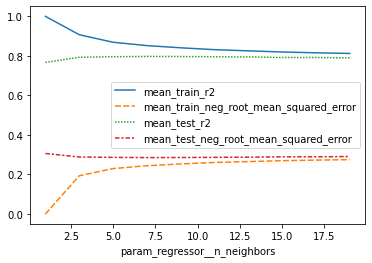

In [547]:
from sklearn.neighbors import KNeighborsRegressor

# chargement du modèle
m1, features = modelpreparation(model1)

# Valeurs possibles du nombre de plus proches voisins
params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = KNeighborsRegressor()

# Preprocessing et fit du modèle
gspipeline = crossval_GS("TotalGHGEmissions_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, axis_scale="linear", plot_param="n_neighbors")

**Second modèle**

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 9}

Sur le jeu de test : 0.734


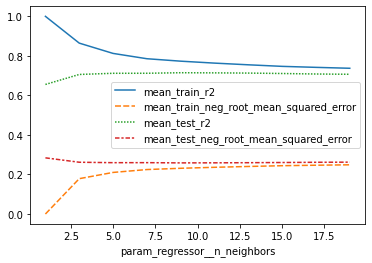

In [548]:
from sklearn.neighbors import KNeighborsRegressor

m2, features = modelpreparation(model2)

# Valeurs possibles du nombre de plus proches voisins
params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = KNeighborsRegressor()

# Preprocessing et fit du modèle
gspipeline = crossval_GS("SiteEnergyUse_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, axis_scale="linear", plot_param="n_neighbors")

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 11}

Sur le jeu de test : 0.824


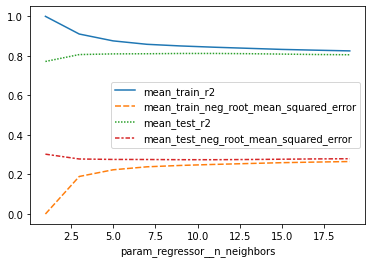

In [549]:
from sklearn.neighbors import KNeighborsRegressor

m2, features = modelpreparation(model2)

# Valeurs possibles du nombre de plus proches voisins
params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = KNeighborsRegressor()

# Preprocessing et fit du modèle
gspipeline = crossval_GS("TotalGHGEmissions_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, axis_scale="linear", plot_param="n_neighbors")

## III.4 Sélection de prédicteurs avec Lasso

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 0.00021544346900318823}

Sur le jeu de test : 0.541


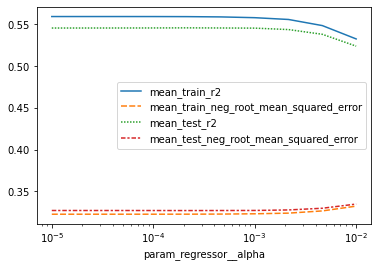

In [467]:
m1, features = modelpreparation(model1)
model = LinearRegression()

# Valeurs possibles du paramètre alpha
params = {"alpha" : np.logspace(-5, -2, 10)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = Lasso(tol=1e-4, max_iter=1e5)

# Preprocessing et fit du modèle
gspipeline = crossval_GS("SiteEnergyUse_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, plot_param="alpha")

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 0.00035938136638046257}

Sur le jeu de test : 0.705


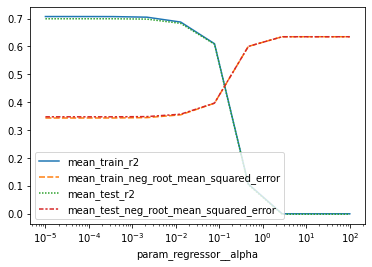

In [470]:
m1, features = modelpreparation(model1)

# Valeurs possibles du paramètre alpha
params = {"alpha" : np.logspace(-5, 2, 10)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = Lasso(tol=1e-4, max_iter=1e5)

# Preprocessing et fit du modèle
gspipeline = crossval_GS("TotalGHGEmissions_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, plot_param="alpha")

**Réduction de la complexité**

On commence par afficher les poids des différentes colonnes pour la valeur optimale de alpha déterminée par validation croisée. On sélectionne ensuite un sous-ensemble de ces colonnes: on ne retiendra que celles dont les poids sont supérieurs à 5%

In [544]:
# chargement du modèle et des variables associées
m1, features = modelpreparation(model1)

# Préparation des sets d'entraînement et de test
X = m1[features]
y = m1["SiteEnergyUse_log"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)


# Récupération des positions des variables utilisées lors de l'ACP. Le tableau numpy est réorganisé lors du 
# preprocessing: par l'ACP on crée 4 nouvelles colonnes placées entre les colonnes numériques et les colonnes 
# catégorielles
pca_cols = ["PropertyGFATotal", 
                    "PropertyGFAParking",
                    "PropertyGFABuilding(s)",
                    "LargestPropertyUseTypeGFA",
                    "SecondLargestPropertyUseTypeGFA",
                    "ThirdLargestPropertyUseTypeGFA"]


X_train_only_numeric = X_train.select_dtypes(include=['float64'])
pca_index = [X_train_only_numeric.columns.get_loc(c) for c in pca_cols]
pca_dict = {"cols":pca_cols, "index":pca_index}

# Utilisation de Lasso pour recherche les valeurs des poids pour alpha déterminé par validation croisée 
# ci-dessus
lasso = Lasso(alpha=2.15e-4, max_iter=1e5)

# Création du pipeline constitué d'une étape de normalisation, d'ACP et de l'estimateur. 
pipeline = create_pipeline(lasso, pca_dict)
pipeline.fit(X_train, y_train)
coefs = pipeline.named_steps['regressor'].coef_

# Affichage des résultats dans un dataframe
# Les colonnes de type numérique (non catégoriel) du dataframe avant transformation
base_cols = X_train.dtypes[X_train.dtypes!='category'].index

# Colonnes correspondant au dataframe transformé
onehot_cols = pipeline.named_steps['preprocessor1'].named_transformers_['cat'].get_feature_names()
updated_cols = pd.Index([c for c in base_cols if not c in pca_cols])
labels = np.concatenate((updated_cols,
                         ['F1', 'F2', 'F3', 'F4'], 
                         onehot_cols,
                         ))
labels = pd.Index(labels)
print("Poids affectés aux différentes variables par Lasso pour alpha=2.15e-3:")
print('')
print(pd.DataFrame(data={"coefficient":np.abs(coefs)}, index=labels)
      .sort_values(by=['coefficient'],
                   ascending=False))

# Utilisation de Lasso pour recherche les valeurs des poids pour alpha déterminé par validation croisée ci-dessus
lasso = Lasso(alpha=2.15e-4, max_iter=1e5)

# Création du pipeline constitué d'une étape de normalisation, d'ACP et de l'estimateur. 
pipeline = create_pipeline(lasso, pca_dict, regressor=False)
X_train_transf = pipeline.fit_transform(X_train)
select = SelectFromModel(estimator=lasso, threshold=0.055).fit(X_train_transf, y_train)
X_train_sel = select.transform(X_train_transf)

print('')
print("Sélection des variables dont le poids est supérieur à 0.055:")
print(f"Nombre de variables avant sélection: {X_train_transf.shape[1]}")
print(f"Nombre de variables après sélection: {X_train_sel.shape[1]}")

Poids affectés aux différentes variables par Lasso pour alpha=2.15e-3:

                                               coefficient
x3_Large Office_Office                        2.751276e-01
x3_Low-Rise Multifamily_Multifamily Housing   2.269145e-01
x3_High-Rise Multifamily_Multifamily Housing  1.751710e-01
F1                                            1.146846e-01
Electricity_ratio                             8.901416e-02
x2_None                                       7.605647e-02
x3_Mid-Rise Multifamily_Multifamily Housing   7.138087e-02
x1_None                                       7.000849e-02
x1_Office                                     6.463653e-02
F2                                            6.043735e-02
F3                                            5.174761e-02
x3_Other_Office                               5.127190e-02
x3_Other_Multifamily Housing                  4.453561e-02
x0_Other                                      4.255807e-02
F4                                         

## III.5 Feature importance avec RandomForest

Premier essai avec l'algorithme RandomForestRegressor sur les mêmes features que précédemment et un nombre d'estimateurs à 100. Le but est à la fois d'obtenir une première estimation par cet algorithme et une mesure des feature_importances dans le but d'optimiser le modèle.

Performance de RandomForestRegressor avec les variables sélectionnées par Lasso

In [553]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


rfr = RandomForestRegressor(n_estimators=100, oob_score=True)
rfr.fit(X_train_transf, y_train)
X_test_transf = pipeline.fit_transform(X_test)
rfr.score(X_test_transf, y_test)

0.7249669328315204

On reprend le jeu de données initial pour déterminer la valeur optimale de l'hyperparamètre n_estimators

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_estimators': 500}

Performance en généralisation sur le jeu de test : 0.852
Performance(s) moyenne(s) sur le jeu d'entraînement:
   mean_train_r2  std_train_r2  mean_train_neg_root_mean_squared_error  \
3       0.974413      0.001034                                0.077678   
4       0.974663      0.000966                                0.077300   
2       0.973404      0.000970                                0.079200   
0       0.969753      0.001477                                0.084447   
1       0.971786      0.001600                                0.081547   

   std_train_neg_root_mean_squared_error  mean_test_r2  std_test_r2  \
3                               0.000833      0.807930     0.018877   
4                               0.000728      0.807128     0.019488   
2                               0.000792      0.805192     0.018541   
0                               0.001312      0.801015     0.017791   

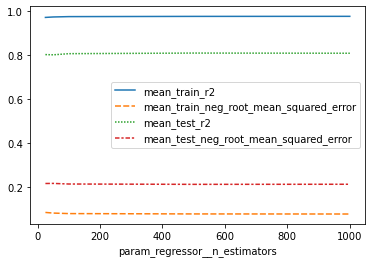

In [588]:
m1, features = modelpreparation(model1)

# Valeurs possibles du paramètre alpha
params = {"n_estimators" : [25,
                            50,
                            100, 500, 1000
                           ]}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
model = RandomForestRegressor(oob_score=True)

# Preprocessing et fit du modèle
gspipeline = crossval_GS("SiteEnergyUse_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults, result_cols = print_cvresults(score, gspipeline, params)

key_prefix = "param_regressor__"

mean_scores = cvresults.loc[
    cvresults[key_prefix+"n_estimators"]==gspipeline.best_params_["regressor__n_estimators"],
    ["mean_train_r2", "mean_train_neg_root_mean_squared_error"]].mean()

print(cvresults[result_cols])
print("Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:")
print("R2: {:.3f} +/- {:.3f}".format(mean_scores[0], cvresults.iloc[0]["std_train_r2"]))
print("RMSE: {:.3f} +/- {:.3f}".format(mean_scores[1], cvresults.iloc[0]["std_train_neg_root_mean_squared_error"]))
    
# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, plot_param="n_estimators", axis_scale='linear')

Feature importances avec RandomForest

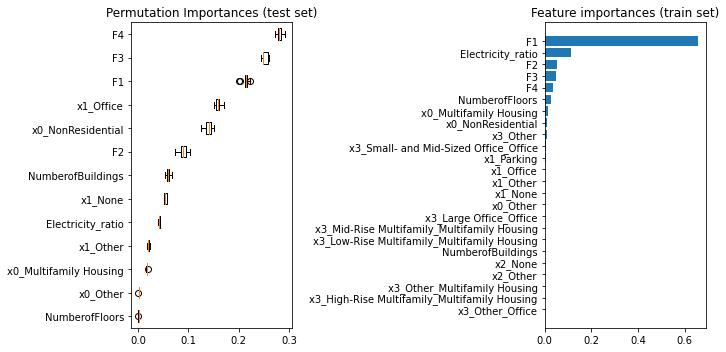

In [608]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

rfr = RandomForestRegressor(n_estimators=500, oob_score=True)
target = "SiteEnergyUse_log"

# chargement du modèle
m1, features = modelpreparation(model1)


# Séparation prédicteurs - cible
X = m1[features]
y = m1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

# Récupération des indices correspondant aux variables sur lesquelles on réalise l'ACP dans le tableau
# numpy créé après preprocessing1. Le tableau numpy est en effet réorganisé lors du preprocessing avec les
# colonnes numeriques d'abord, puis les colonnes créées lors de l'ACP et enfin les colonnes catégorielles
# colonnes sur lesquelles appliquer l'ACP
pca_cols = ["PropertyGFATotal", 
            "PropertyGFAParking",
            "PropertyGFABuilding(s)",
            "LargestPropertyUseTypeGFA",
            "SecondLargestPropertyUseTypeGFA",
            "ThirdLargestPropertyUseTypeGFA"]

X_train_only_numeric = X_train.select_dtypes(include=['float64'])
pca_index = [X_train_only_numeric.columns.get_loc(c) for c in pca_cols]
pca_dict = {"cols":pca_cols, "index":pca_index}

# Création du pipeline constitué d'une étape de normalisation, d'ACP et de l'estimateur. 
reg = create_pipeline(rfr, pca_dict)

# Fit transform
reg.fit(X_train, y_train)

# Permutation importance
result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=0)
sorted_idx = result.importances_mean.argsort()

# Feature importances
feat_importances = reg.named_steps['regressor'].feature_importances_

# Affichage des résultats dans un dataframe
# Les colonnes de type numérique (non catégoriel) du dataframe avant transformation
base_cols = X_train.dtypes[X_train.dtypes!='category'].index

# Colonnes correspondant au dataframe transformé
onehot_cols = pipeline.named_steps['preprocessor1'].named_transformers_['cat'].get_feature_names()
updated_cols = pd.Index([c for c in base_cols if not c in pca_cols])
labels = np.concatenate((updated_cols,
                         ['F1', 'F2', 'F3', 'F4'], 
                         onehot_cols,
                         ))
labels = pd.Index(labels)    


feature_importances = pd.DataFrame(data={"feature importance":np.abs(feat_importances)},
                                   index=labels).sort_values(by=['feature importance'],
                                                             ascending=False)

# Affichage des features par ordre d'importance
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=labels[sorted_idx])
ax1.set_title("Permutation Importances (test set)")

f = feature_importances["feature importance"]
ax2.barh(f.index, f)
ax2.set_title("Feature importances (train set)")
ax2.invert_yaxis()
fig.tight_layout()
plt.show()

## IV ENERGYSTARScore

Comme vu lors de l'analyse exploratoire, ENERGYSTARScore est corrélée à SourceEUIWN, GHGEmissionsIntensity, et ces dernières sont corrélées à TotalGHGEmissions via PropertyGFABuilding(s). On va donc créer un modèle basé en premier lieu sur ces variables.

R2 sur le jeu de données: 0.06726279089552156


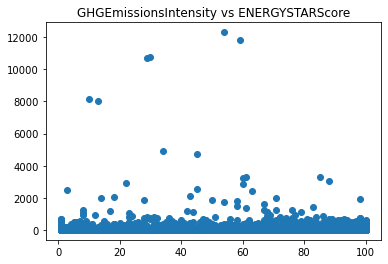

R2 sur le jeu de données: 0.5247095239647329


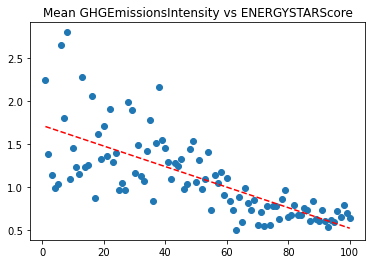

In [639]:
# prédicteurs
escmodel = model1.copy()
escmodel.dropna(subset=["ENERGYSTARScore"], inplace=True)

features = "ENERGYSTARScore"
target = "GHGEmissionsIntensity"

X = escmodel[features].values.reshape(-1, 1)
y = escmodel[target].values

# Régression linéaire sur les données brutes
lr = LinearRegression()
lr.fit(X, y)
print("R2 sur le jeu de données: {}".format(lr.score(X,y)))
coef = lr.coef_
intercept = lr.intercept_

fig, ax = plt.subplots()
ax.scatter(x=escmodel["ENERGYSTARScore"], y=escmodel["TotalGHGEmissions"])
ax.plot(escmodel["ENERGYSTARScore"], intercept + escmodel["ENERGYSTARScore"]*coef, '--')
ax.set_title("GHGEmissionsIntensity vs ENERGYSTARScore")
plt.show()

# Régression linéaire sur les valeurs moyennes de GHGEmissionsIntensity pour chaque valeur de ENERGYSTARScore
X = escmodel.groupby(features).mean()[target].index.to_numpy().reshape(-1, 1)
y = escmodel.groupby(features).mean()[target].values

lr.fit(X, y)
print("R2 sur le jeu de données: {}".format(lr.score(X,y)))
coef = lr.coef_
intercept = lr.intercept_

indices = escmodel.groupby(features).mean()[target].index.values
fig, ax = plt.subplots()
ax.scatter(escmodel.groupby(features).mean()[target].index.to_numpy(),  y)
ax.plot(indices, intercept + indices*coef, 'r--')
ax.set_title("Mean GHGEmissionsIntensity vs ENERGYSTARScore")
plt.show()

# VI Choix du modèle

In [ ]:
index = ["mean_test_r2", "mean_train_r2","mean_test_neg_root_mean_squared_error", "mean_fit_time"]
d = {"Ridge":log_ridgebestresult[index], 
      "Lasso":log_lassobestresult[index],
      "kNN":log_knnbestresult[index],
      "SVM":log_svm_bestresult[index], 
      "SVM Non-linéaire": log_kernelsvm_bestresult[index],
      "randomforest":log_randomforestbestresult[index], 
      "gradient boosting":log_grboostbestresult[index]}
model_1 = pd.DataFrame(data=d)
model_1

In [ ]:
def benchmark(reg):

    t0 = time()
    reg.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = reg.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

for clf, name in (
        (LinearRegression(), "Linear Regression"),
        (Lasso(alpha=), "Lasso"),
        (Lasso(), "Lasso"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestRegressor(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))